In [ ]:
import numpy as np
import cv2

def movingAverage(curve, radius):
    window_size = 2 * radius + 1
    f = np.ones(window_size) / window_size
    curve_pad = np.pad(curve, (radius, radius), 'edge')
    curve_smoothed = np.convolve(curve_pad, f, mode='same')
    curve_smoothed = curve_smoothed[radius:-radius]
    return curve_smoothed

def smooth(trajectory):
    smoothed_trajectory = np.copy(trajectory)
    for i in range(3):
        smoothed_trajectory[:, i] = movingAverage(trajectory[:, i], radius=SMOOTHING_RADIUS)
    return smoothed_trajectory

def fixBorder(frame):
    s = frame.shape
    T = cv2.getRotationMatrix2D((s[1] / 2, s[0] / 2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

SMOOTHING_RADIUS = 50

cap = cv2.VideoCapture('motorcycles.mp4')

if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('motorcycles_stabilized.mp4', fourcc, fps, (2 * w, h))
# out = cv2.VideoWriter('video_stabilized.mp4', fourcc, fps, (w, h))

if not out.isOpened():
    print("Error: Could not open video writer with codec 'mp4v'")
    exit()
else:
    print("Video writer opened successfully with codec 'mp4v'")

_, prev = cap.read()

if prev is None:
    print("Error: Could not read the first frame.")
    exit()

prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
transforms = np.zeros((n_frames - 1, 3), np.float32)

for i in range(n_frames - 1):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30, blockSize=3)
    success, curr = cap.read()
    if not success:
        break

    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

    assert prev_pts.shape == curr_pts.shape

    idx = np.where(status == 1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    m, _ = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
    if m is None:
        m = np.eye(2, 3, dtype=np.float32)
    dx = m[0, 2]
    dy = m[1, 2]
    da = np.arctan2(m[1, 0], m[0, 0])

    transforms[i] = [dx, dy, da]
    prev_gray = curr_gray

    print("Frame: " + str(i) + "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts)))



trajectory = np.cumsum(transforms, axis=0)
smoothed_trajectory = smooth(trajectory)
difference = smoothed_trajectory - trajectory
transforms_smooth = transforms + difference

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for i in range(n_frames - 1):
    success, frame = cap.read()
    if not success:
        break

    dx = transforms_smooth[i, 0]
    dy = transforms_smooth[i, 1]
    da = transforms_smooth[i, 2]

    m = np.zeros((2, 3), np.float32)
    m[0, 0] = np.cos(da)
    m[0, 1] = -np.sin(da)
    m[1, 0] = np.sin(da)
    m[1, 1] = np.cos(da)
    m[0, 2] = dx
    m[1, 2] = dy

    frame_stabilized = cv2.warpAffine(frame, m, (w, h)) 
    frame_stabilized = fixBorder(frame_stabilized)
    frame_out = cv2.hconcat([frame, frame_stabilized])
    # frame_out = frame_stabilized

    out.write(frame_out)
    if frame_out.shape[1] > 1600 or frame_out.shape[0] > 900: 
        frame_out = cv2.resize(frame_out, (frame_out.shape[1]//2, frame_out.shape[0]//2))
    cv2.imshow("Before and After", frame_out)
    cv2.waitKey(10)

cap.release()
out.release()
cv2.destroyAllWindows()


Video writer opened successfully with codec 'mp4v'
Frame: 0/930 -  Tracked points : 162
Frame: 1/930 -  Tracked points : 165
Frame: 2/930 -  Tracked points : 169
Frame: 3/930 -  Tracked points : 158
Frame: 4/930 -  Tracked points : 163
Frame: 5/930 -  Tracked points : 163
Frame: 6/930 -  Tracked points : 172
Frame: 7/930 -  Tracked points : 179
Frame: 8/930 -  Tracked points : 178
Frame: 9/930 -  Tracked points : 192
Frame: 10/930 -  Tracked points : 187
Frame: 11/930 -  Tracked points : 188
Frame: 12/930 -  Tracked points : 190
Frame: 13/930 -  Tracked points : 180
Frame: 14/930 -  Tracked points : 196
Frame: 15/930 -  Tracked points : 191
Frame: 16/930 -  Tracked points : 188
Frame: 17/930 -  Tracked points : 175
Frame: 18/930 -  Tracked points : 176
Frame: 19/930 -  Tracked points : 194
Frame: 20/930 -  Tracked points : 183
Frame: 21/930 -  Tracked points : 178
Frame: 22/930 -  Tracked points : 193
Frame: 23/930 -  Tracked points : 183
Frame: 24/930 -  Tracked points : 182
Frame: 25

In [3]:
import matplotlib.pyplot as plt

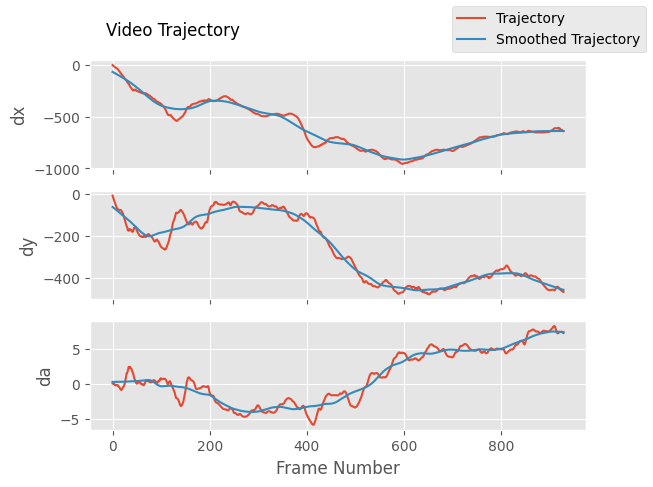

In [18]:
with plt.style.context('ggplot'):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex='all')

    # x trajectory
    ax1.plot(trajectory[:, 0], label='Trajectory')
    ax1.plot(smoothed_trajectory[:, 0], label='Smoothed Trajectory')
    ax1.set_ylabel('dx')

    # y trajectory
    ax2.plot(trajectory[:, 1], label='Trajectory')
    ax2.plot(smoothed_trajectory[:, 1], label='Smoothed Trajectory')
    ax2.set_ylabel('dy')

    # angle trajectory
    ax3.plot(np.rad2deg(trajectory[:, 2]), label='Trajectory')
    ax3.plot(np.rad2deg(smoothed_trajectory[:, 2]), label='Smoothed Trajectory')
    ax3.set_ylabel('da')

    handles, labels = ax3.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.xlabel('Frame Number')

    fig.suptitle('Video Trajectory', x=0.15, y=0.96, ha='left')
    fig.canvas.manager.set_window_title('Trajectory')